# Homework Solutions

## Dataset
Bank Marketing dataset:
https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv


**In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not.**


In [2]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [1]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

np.set_printoptions(legacy='1.25')


In [2]:
raw_df = pd.read_csv("course_lead_scoring.csv")

In [3]:
raw_df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [4]:
raw_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
lead_source,paid_ads,social_media,events,paid_ads,referral,events,social_media,social_media,referral,paid_ads
industry,NaN,retail,healthcare,retail,education,manufacturing,technology,NaN,healthcare,other
number_of_courses_viewed,1,1,5,2,3,1,0,5,4,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0,59904.0,51283.0,62975.0,38648.0,59866.0
employment_status,unemployed,employed,unemployed,NaN,self_employed,NaN,NaN,student,unemployed,student
location,south_america,south_america,australia,australia,europe,africa,middle_east,europe,south_america,australia
interaction_count,4,1,3,1,3,6,2,4,2,3
lead_score,0.94,0.8,0.69,0.87,0.62,0.83,0.57,0.62,0.86,0.43
converted,1,0,1,0,1,1,0,1,1,1


In [5]:
target = 'converted'

In [6]:
df = raw_df.copy()
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0)

In [9]:
def train_val_test_split(df, target, test_size=0.2, random_state=1):
    
   
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    val_size = len(df_test) / len(df_full_train)
    
    df_train, df_val = train_test_split(df_full_train, test_size=val_size, random_state=random_state)
    
    # Reset index
    df_full_train = df_full_train.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    # Save remove target from the dataframes
    y_full_train = df_full_train[target]
    y_train = df_train[target]
    y_val = df_val[target]
    y_test = df_test[target]
    
    # Remove target from dataframes
    del df_train[target]
    del df_val[target]
    del df_test[target]

    return df_full_train, df_train, df_val, df_test, y_full_train, y_train, y_val, y_test

In [10]:
df_full_train, df_train, df_val, df_test, y_full_train, y_train, y_val, y_test = train_val_test_split(df, target)

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [11]:
auc_scores = []
for n in numerical:
    auc = roc_auc_score(y_train, df_train[n])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[n])
    auc_scores.append(auc)

In [12]:
print("Numerical variables ---> AUC scores")
for n, score in sorted(zip(numerical, auc_scores), key=lambda x: x[1], reverse=True):
    print(f"{n} ---> {score:.3f}")

Numerical variables ---> AUC scores
number_of_courses_viewed ---> 0.764
interaction_count ---> 0.738
lead_score ---> 0.614
annual_income ---> 0.552


## Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [13]:
dv = DictVectorizer(sparse=False)

In [14]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [15]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)

In [16]:
print(f"AUC score (liblinear): {auc_score:.2f}")


AUC score (liblinear): 0.82


In [17]:
# Testing with lbfgs solver
# model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
# model.fit(X_train, y_train)
# y_pred = model.predict_proba(X_val)[:, 1]
# auc_score = roc_auc_score(y_val, y_pred)

In [18]:
# print(f"AUC score (lbfgs): {auc_score:.2f}")

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [19]:
scores = []
thresholds = np.linspace(0, 1, 101)
t_optimal = None
for t in thresholds:
    predict_positive = (y_pred >= t)

    precision = precision_score(y_val, predict_positive, zero_division=0)
    recall = recall_score(y_val, predict_positive, zero_division=0)
    scores.append((t, precision, recall))

In [20]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
    
df_scores['precision'] = df_scores.precision / (df_scores.precision + df_scores.recall)
df_scores['fpr'] = df_scores.recall / (df_scores.recall + df_scores.precision)

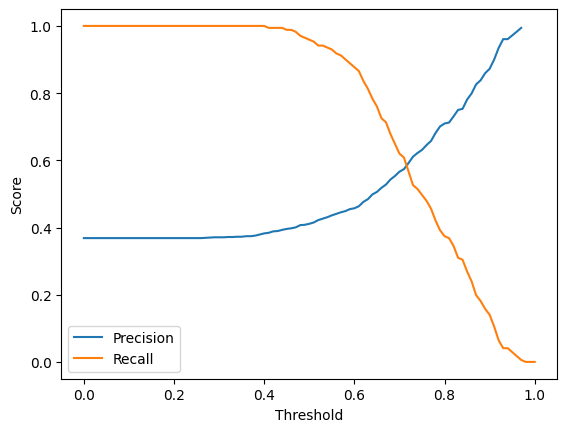

In [21]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [22]:
t_optimal = None

for score in scores:
    if score[1] >= score[2]:
        t_optimal = score[0]
        break

In [23]:
print(t_optimal)

0.65


## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [24]:
f1_scores = []
for score in scores:
    predict_positive = (y_pred >= score[0])

    f1 = f1_score(y_val, predict_positive, zero_division=0),
    f1_scores.append(f1)

In [25]:
# Max f1 score threshold
max_f1_index = np.argmax(f1_scores)
t_max_f1 = scores[max_f1_index][0]

In [26]:
print(f"F1 max: {f1_scores[max_f1_index][0]:.2f}\nF1 max threshold: {t_max_f1:.2f}")

F1 max: 0.81
F1 max threshold: 0.57


## Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [27]:
from sklearn.model_selection import KFold


In [35]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [36]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm.notebook import tqdm  # better for jupyter notebooks

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    

    n_splits = 5

    # for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []


    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        # print(f"auc: {auc:.3f}")
    
    for score in scores:
        print(f"Score: {score:.3f}")
    print(f"Standard Deviation: {np.std(scores):.3f}") 

Score: 0.806
Score: 0.871
Score: 0.775
Score: 0.802
Score: 0.856
Standard Deviation: 0.036


## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.